In [84]:
import pandas as pd
import glob
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from matplotlib.patches import Patch
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
import cartopy.feature as cfeature

In [2]:
kcutoffs = pd.read_csv('ko_list', sep='\t', index_col=0)
llist = ['Teuk', 'Geuk', 'Tbact', 'Gbact']

ev_dict = {}
for ev in glob.glob('downloads/K00011/*/environmental_parameters.csv'):
    dd = pd.read_csv(ev, sep='\t', index_col='sample_ID')
    ev_dict[ev] = dd
env_params = pd.concat(ev_dict).reset_index().drop('level_0', axis=1).set_index('sample_ID')
env_params = env_params.drop_duplicates(keep='first')

In [3]:
aln_dict = {}
full_dict = {}
ndict  = {}
for lk in glob.glob('downloads/K*'):
    fdict = {}
    ndict = {} 
    k = os.path.basename(lk)
    cutoff = float(kcutoffs.loc[k, 'threshold'])
    for t in llist:
        f = os.path.join(lk, t, '_'.join([k, t, 'aln_result.tsv']))
        if os.stat(f).st_size == 0:
            ndict[t] = pd.DataFrame()
            pass
        else:
            df = pd.read_csv(f, skiprows=8, sep = '\t', index_col=1)
            if 'euk' in t:
                df.index = df.index.str.split("_").str[0:2].str.join('_')    
            passing_genes = df[df.bit_score>cutoff]
            ndict[t] = passing_genes.index
            fdict[t] = df.index
    aln_dict[k] = ndict
    full_dict[k] = fdict

In [5]:
# Read in all abundance files from ocean viewer
ndict = {}
abund_dict = {}
for lk in glob.glob('downloads/K*'):
    ndict = {}
    k = os.path.basename(lk)
    for t in llist:
        f = os.path.join(lk, t, 'abundance_matrix.csv')

        if os.stat(f).st_size == 0:
            ndict[t]=pd.DataFrame()
            pass
        else:
            df = pd.read_csv(f, sep ='\t', header = 0, skiprows=1, index_col=0)
            ndict[t]=df
    abund_dict[k] = ndict

In [128]:
# limit abundances to just those that are passing the hmm threshold

subset_abund = {}
for lk in glob.glob('downloads/K*'):
    k = os.path.basename(lk)
    ndict = {}
    for t in llist:
        
        subset = set(abund_dict[k][t].index).intersection(aln_dict[k][t])
        aa = abund_dict[k][t].loc[subset]
        ndict[t]=aa
    subset_abund[k]=ndict

In [129]:
total_counts = pd.DataFrame(index = full_dict.keys(), columns = ['MATOU_total', 'OM-RGC_total','MATOU_hmmpass', 'OM-RGC_hmmpass', ] )
for key in full_dict:
    for t in full_dict[key]:
        if 'euk' in t:
            euk = len(full_dict[key][t])
            euk_aln = len(aln_dict[key][t])
        else:
            bact = len(full_dict[key][t])
            bact_aln = len(aln_dict[key][t])
    total_counts.loc[key, 'MATOU_total']=euk
    total_counts.loc[key, 'OM-RGC_total']=bact
    total_counts.loc[key, 'MATOU_hmmpass']=euk_aln
    total_counts.loc[key, 'OM-RGC_hmmpass']=bact_aln
total_counts.to_csv('figures/Total_counts.csv')
total_counts

,MATOU_total,OM-RGC_total,MATOU_hmmpass,OM-RGC_hmmpass
K00130,52672,69831,54,259
K17742,45896,154362,139,11
K10227,123,1864,10,276
K00008,20555,43624,469,12
K00315,12017,58388,105,810
K08261,44855,152543,0,0
K17755,7629,19487,0,0
K00305,61,4856,11,544
K00544,9705,7613,4267,1282
K00011,37518,4645,158,0


In [130]:
K = 'K02002'

def count_taxa(K, dtype='Tbact'):
    df = subset_abund[K][dtype]
    if 'taxonomy' in df.columns:
        t = df.groupby('taxonomy').count().iloc[:,0].sort_values(ascending=False)
        t=pd.DataFrame(t)
        t.columns = ['count']
    else:
        t=None
    return(t)
# taxa = df.taxonomy.str.split(';', expand = True)
# df.merge(taxa, left_index=True, right_index=True)

In [131]:
df = pd.read_csv('../input/Osmolyte-Reactions.tsv', sep='\t')
df.ORTHOLOGY = df.ORTHOLOGY.str.split(';')
df = df[df['ORTHOLOGY'].notna()]
df['COMBINED_ORTHO'] = df[['NAMED_GROUP', 'PATHWAY']].astype(str).agg(':'.join, axis=1)
df['COMBINED_ORTHO_STEP'] = df[['NAMED_GROUP', 'PATHWAY', 'STEP']].astype(str).agg(':'.join, axis=1)
df['max_step']= df.groupby('COMBINED_ORTHO')['STEP'].transform('max')
df['ALLKO']=df.groupby('COMBINED_ORTHO_STEP')['ORTHOLOGY'].transform(sum)

#Subset the DF to just columns that we will be using
subset_df = df[['COMPOUND_NAME','COMPOUND','BROAD', 'NAMED_GROUP', 'COMBINED_ORTHO','COMBINED_ORTHO_STEP', 'ALLKO', 'max_step']]
subset_df = subset_df.loc[subset_df[['COMPOUND_NAME','COMPOUND','BROAD', 'NAMED_GROUP', 'COMBINED_ORTHO','COMBINED_ORTHO_STEP']].drop_duplicates().index]

metabolite_dict = pd.read_csv('../input/types.csv')[['metabolite', 'gentype']].set_index('metabolite').to_dict()['gentype']
#Index by KOs in an explosive fashion
ko_indexed = subset_df.explode('ALLKO').set_index('ALLKO')
ko_indexed['TYPE'] = ko_indexed.COMPOUND_NAME.map(metabolite_dict)
ko_indexed

,COMPOUND_NAME,COMPOUND,BROAD,NAMED_GROUP,COMBINED_ORTHO,COMBINED_ORTHO_STEP,max_step,TYPE
ALLKO,,,,,,,,
K00864,Glycerol,C00116,BREAKDOWN,Glycerol breakdown to sn-Glycerol 3-phosphate,Glycerol breakdown to sn-Glycerol 3-phosphate:1,Glycerol breakdown to sn-Glycerol 3-phosphate:1:1,1,Sugar alcohol
K00863,Glycerol,C00116,BREAKDOWN,Glycerol breakdown Glycerone phosphate,Glycerol breakdown Glycerone phosphate:1,Glycerol breakdown Glycerone phosphate:1:2,2,Sugar alcohol
K05878,Glycerol,C00116,BREAKDOWN,Glycerol breakdown Glycerone phosphate,Glycerol breakdown Glycerone phosphate:1,Glycerol breakdown Glycerone phosphate:1:2,2,Sugar alcohol
K05879,Glycerol,C00116,BREAKDOWN,Glycerol breakdown Glycerone phosphate,Glycerol breakdown Glycerone phosphate:1,Glycerol breakdown Glycerone phosphate:1:2,2,Sugar alcohol
K05881,Glycerol,C00116,BREAKDOWN,Glycerol breakdown Glycerone phosphate,Glycerol breakdown Glycerone phosphate:1,Glycerol breakdown Glycerone phosphate:1:2,2,Sugar alcohol
...,...,...,...,...,...,...,...,...
K10674,Ectoine,C06231,BREAKDOWN,Ectoine transformation to 5-Hydroxyectoine,Ectoine transformation to 5-Hydroxyectoine:1,Ectoine transformation to 5-Hydroxyectoine:1:1,1,Amino acid
K15783,Ectoine,C06231,BREAKDOWN,Ectoine recycling,Ectoine recycling:1,Ectoine recycling:1:1,3,Amino acid
K15784,Ectoine,C06231,BREAKDOWN,Ectoine recycling,Ectoine recycling:1,Ectoine recycling:1:2,3,Amino acid


In [132]:
def get_all_genes_summed(dtype='Tbact'):
    dict_k = {}
    for k in subset_abund.keys():
        if 'taxonomy' in subset_abund[k][dtype]:
            kdf = pd.DataFrame(subset_abund[k][dtype].drop('taxonomy', axis=1).sum().sort_values())
            kdf.columns = [k]
            dict_k[k] = kdf
    bigd = pd.concat(dict_k, axis = 1)
    bigd.columns = bigd.columns.get_level_values(0)
    return(bigd)

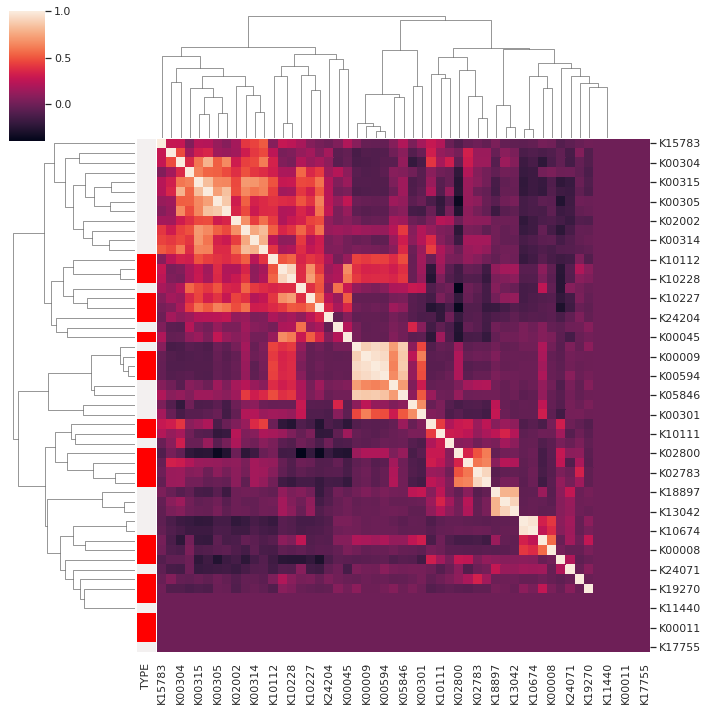

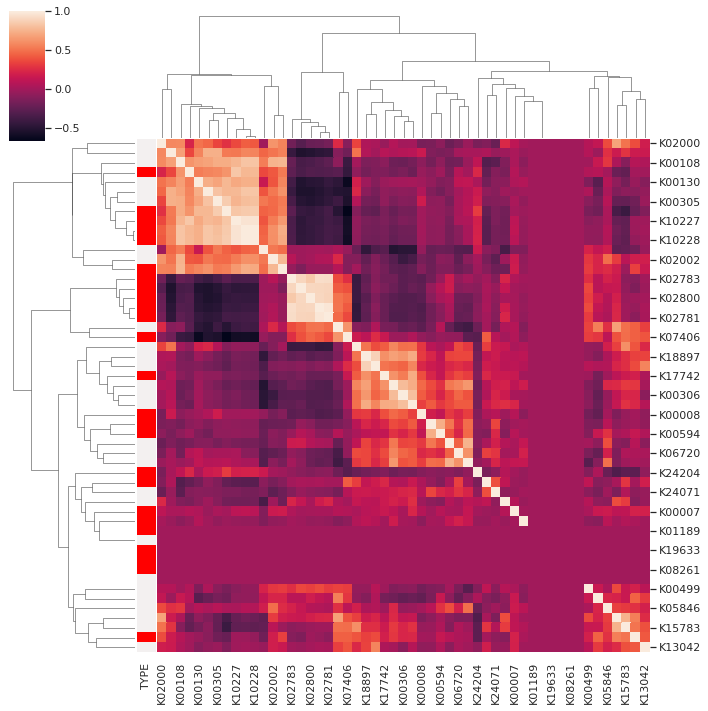

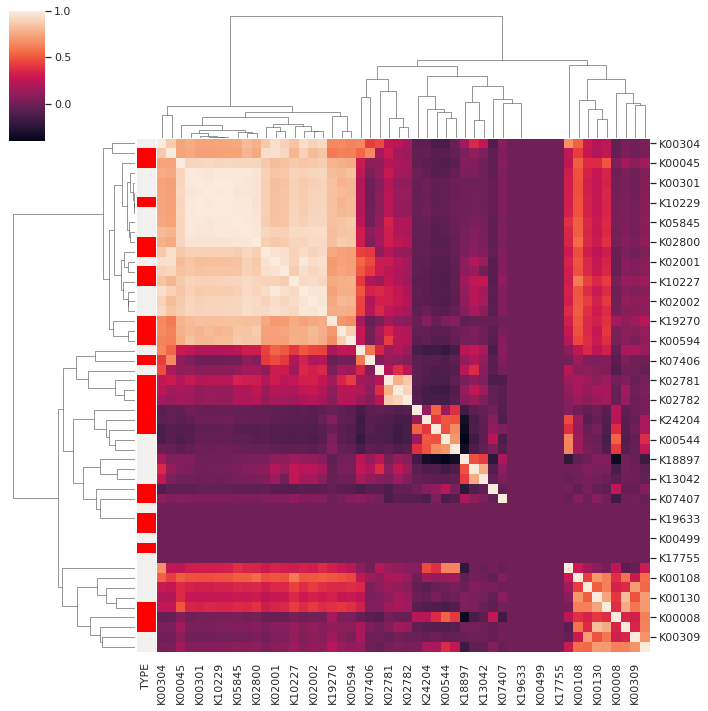

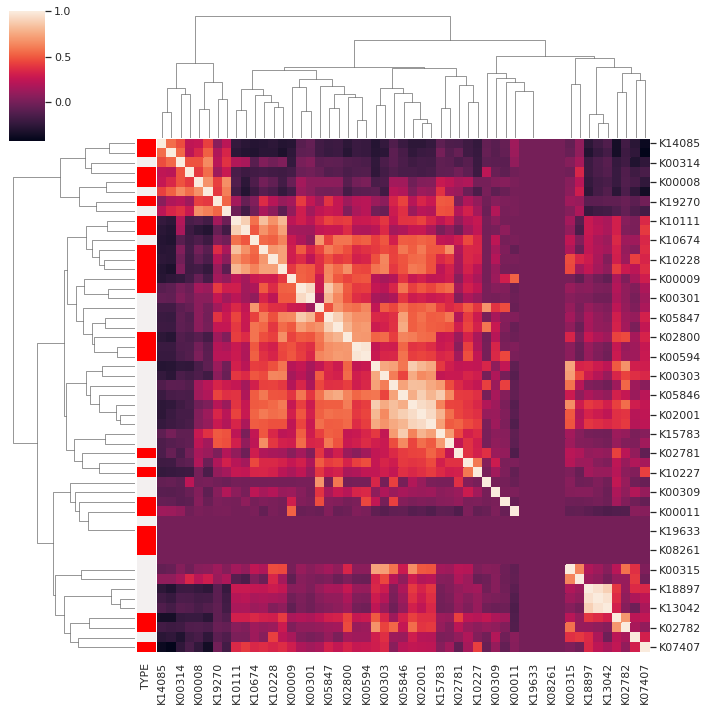

In [141]:

def corr_data(Tbact_summed):
    Tbact_summed_corr = Tbact_summed.corr('pearson')
    type_mol = pd.DataFrame(ko_indexed.loc[Tbact_summed.corr().index].TYPE).reset_index().drop_duplicates().sort_values('ALLKO').replace('Sugar', 'Sugar alcohol').drop_duplicates().set_index('ALLKO')
    type_col = type_mol.to_dict()['TYPE']
    Tbact_summed_corr['TYPE'] = Tbact_summed_corr.index.map(type_col)
    network_pal = sns.light_palette('red', len(Tbact_summed_corr.TYPE.unique()))
    network_lut = dict(zip(Tbact_summed_corr.TYPE.unique(), network_pal))
    network_colors = pd.Series(Tbact_summed_corr.TYPE).map(network_lut)
    # Teuk_summed = get_all_genes_summed(dtype='Teuk')
    sns.clustermap(Tbact_summed_corr.fillna(0)[Tbact_summed_corr.index], row_colors=network_colors)
    Tbact_summed_env = Tbact_summed.merge(env_params, left_index=True, right_index=True, how='left')
    Tbact_summed_env = Tbact_summed_env[~Tbact_summed_env.index.duplicated(keep='first')]
    return(Tbact_summed_corr, Tbact_summed_env)

Tbact_summed = get_all_genes_summed()

Tbact_summed_corr, Tbact_summed_env = corr_data(Tbact_summed)


Gbact_summed = get_all_genes_summed(dtype='Gbact')

Gbact_summed_corr, Gbact_summed_env = corr_data(Gbact_summed)

Teuk_summed = get_all_genes_summed(dtype='Teuk')

Teuk_summed_corr, Teuk_summed_env = corr_data(Teuk_summed)


Geuk_summed = get_all_genes_summed(dtype='Geuk')

Geuk_summed_corr, Geuk_summed_env = corr_data(Geuk_summed)

In [31]:
compound_dict = {}
for g, n in ko_indexed.loc[Tbact_summed.columns].groupby('COMPOUND_NAME'):
    compound_dict[g]= sorted(list(set(n.index)))
    
def Kplot_maps_overlay(Tbact_summed_env, K='K00130', scale = 10e5):
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
        
    for depth, color in zip(['SRF', 'DCM', 'MES'], ['green', 'blue', 'red']):
        subset = Tbact_summed_env[Tbact_summed_env['depth']==depth]
        ax.scatter(x =subset.longitude, y=subset.latitude, 
               s= subset[K]*scale, transform=ccrs.PlateCarree(), alpha=0.5,color=color)
    plt.show()
    
def Kplot_maps_subplot(Tbact_summed_env, Klist=['K00130'], kname='test', scale = 10e5, color='blue', depth_list = ['SRF', 'DCM', 'MES']):
    fig = plt.figure(figsize=(12, 12))
    gs = fig.add_gridspec(len(Klist), 3)
    for i, k in enumerate(Klist):
        for j,d in enumerate(depth_list):
            subset = Tbact_summed_env[Tbact_summed_env['depth']==d]
            ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())
            ax.coastlines()
            ax.scatter(x =subset.longitude, y=subset.latitude, 
               s= subset[k]*scale, transform=ccrs.PlateCarree(), alpha=0.8,color=color)
            ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
            if j == 0:
                ax.text(-350,1, k, fontsize=14)

            if i ==0:
                ax.set_title(d)

    plt.savefig(kname+'_Tbact.pdf')
    return()

In [32]:
for g, n in ko_indexed.loc[Tbact_summed.columns].groupby('COMPOUND_NAME'):
    compound_dict[g]= set(n.index)


In [33]:
bd_groups = {}
for group, df in ko_indexed.groupby(['COMPOUND_NAME', 'BROAD']):
    bd_groups[group]= sorted(list(set(df.index)))
    

In [34]:
GBsets = [('Glycine betaine', 'BREAKDOWN'), ('Glycine betaine', 'SYNTHESIS'), ('Glycine betaine', 'TRANSPORT')]
Msets = [('Mannitol', 'BREAKDOWN'), ('Mannitol', 'SYNTHESIS'), ('Mannitol', 'TRANSPORT'),]

In [53]:
sns.set(rc={'figure.figsize':(20,10)})

def create_box_plot(Tbact_summed, compound = 'Glycine betaine', colors = ['#6E8A0F','#A1A1A1']):
    Trans = Tbact_summed[bd_groups[(compound, 'TRANSPORT')]]
    Syn = Tbact_summed[Tbact_summed.columns.intersection(bd_groups[(compound, 'SYNTHESIS')])]
    BD = Tbact_summed[Tbact_summed.columns.intersection(bd_groups[(compound, 'BREAKDOWN')])]
    SynBD = Syn.merge(BD, left_index = True, right_index=True, how='inner')
    print(SynBD.columns)
    cdict = {}
    for t, c in zip([Trans, SynBD], colors):
        for k in t.columns:
            cdict[k]=c
    tt = Trans.merge(SynBD, left_index=True, right_index=True)
    g = sns.boxplot(data = tt,palette=cdict)
    g.set_yscale('log')
    return(tt, cdict)

Index(['K00130', 'K17755', 'K00499', 'K14085', 'K18897', 'K24071', 'K18896',
       'K11440', 'K13042', 'K00108', 'K00315', 'K00305', 'K00544', 'K00314',
       'K00304', 'K00303', 'K00309', 'K00302', 'K00306', 'K00301'],
      dtype='object')


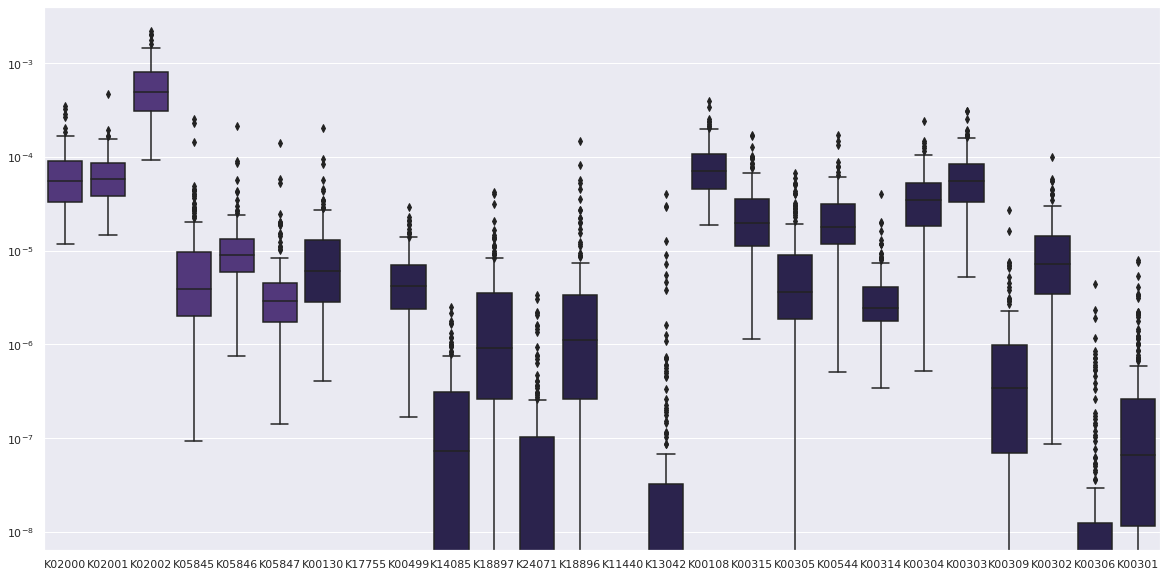

In [54]:
GB_combo, GB_cdict = create_box_plot(Tbact_summed, compound='Glycine betaine', colors  = ['#4F2D86','#271C54'])
plt.savefig('figures/Glycine_betaine_distributions.pdf')

Index(['K00008', 'K19270_x', 'K00007_x', 'K24204_x', 'K00009_x', 'K00045_x',
       'K19270_y', 'K02798', 'K00007_y', 'K24204_y', 'K00009_y', 'K00045_y',
       'K02800'],
      dtype='object')


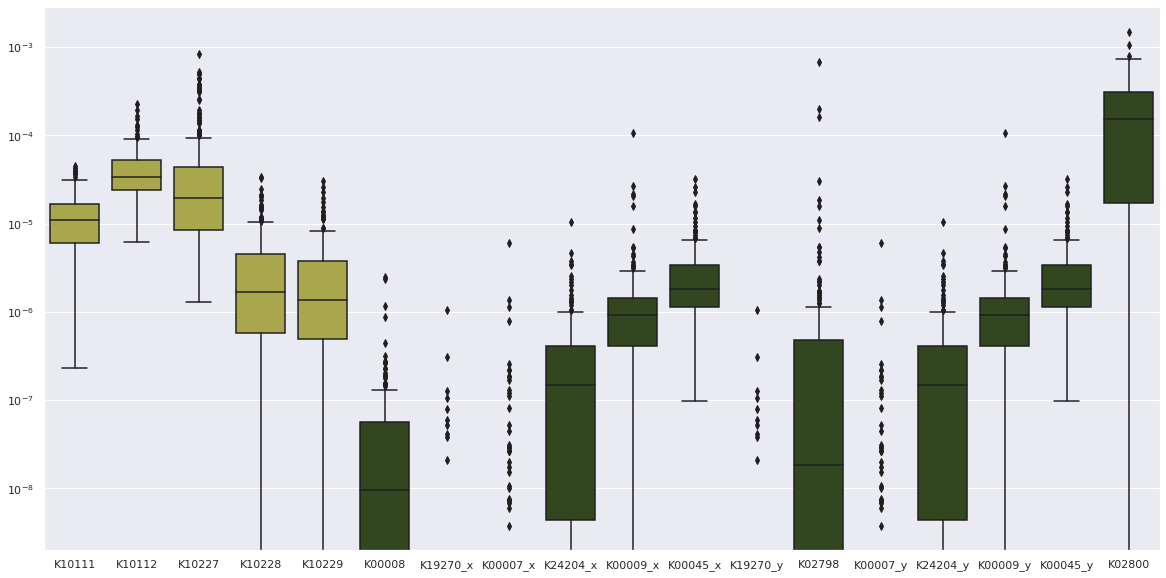

In [55]:
M_combo, M_cdict = create_box_plot(Tbact_summed, compound='Mannitol', colors = ['#B8B63D','#314D19'])
plt.savefig('figures/Manitol_distributions.pdf')

all_cdict={}
for key in M_cdict.keys():
    nk = key.strip('_x').strip('_y') 
    all_cdict[nk] = M_cdict[key]
for key in GB_cdict.keys():
    all_cdict[key]=GB_cdict[key]
    
for M in  M_combo.columns:
    if M.endswith('_y'):
        M_combo = M_combo.drop(M, axis=1)    
cols =[ M.strip('_x') for M in M_combo]
M_combo.columns = cols

In [56]:
M_set = set(key.strip('_x').strip('_y') for key in M_cdict.keys())
GB_set = set(GB_cdict.keys())

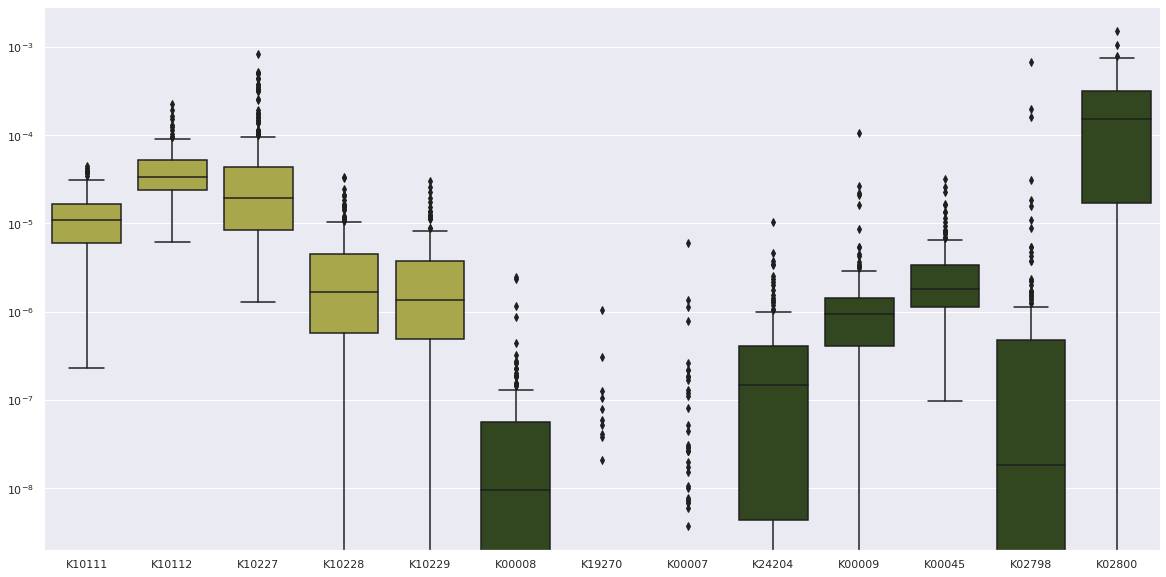

In [57]:
g = sns.boxplot(data = M_combo,palette=all_cdict)
g.set_yscale('log')
plt.savefig('figures/Manitol_distributions.pdf')

In [46]:
MGB_combo = M_combo.merge(GB_combo, left_index=True, right_index=True)
MGB_combo_corr = MGB_combo.corr('spearman')
MGB_combo_corr = MGB_combo_corr.dropna(axis=1, how='all').dropna(axis=0, how='all')
row_colors = MGB_combo_corr.index.map(all_cdict)
row_colors


Index(['#B8B63D', '#B8B63D', '#B8B63D', '#B8B63D', '#B8B63D', '#314D19',
       '#314D19', '#314D19', '#314D19', '#314D19', '#314D19', '#314D19',
       '#314D19', '#4F2D86', '#4F2D86', '#4F2D86', '#4F2D86', '#4F2D86',
       '#4F2D86', '#271C54', '#271C54', '#271C54', '#271C54', '#271C54',
       '#271C54', '#271C54', '#271C54', '#271C54', '#271C54', '#271C54',
       '#271C54', '#271C54', '#271C54', '#271C54', '#271C54', '#271C54',
       '#271C54'],
      dtype='object')

In [47]:
test = env_params.merge(MGB_combo, left_index=True, right_index=True, how='inner').corr()
cols = ['Temperature (°C)', 'Salinity (PSU)',
       'Density (kg/m**3)', 'Distance_coast (km)', 'Chlorophyll_A (mg/m**3)',
       'PAR (mol quanta/m**2/day)', 'O2 (µmol/kg)', 'NO3 (µmol/l)',
       'Iron_5m* (µmol/l)', 'Ammonium_5m* (µmol/l)', 'Nitrite_5m* (µmol/l)',
       'Nitrate_5m* (µmol/l)', 'CDOM* (ppb (QSE))', 'NPP_C* (mg/m**2/day)',
       'POC* (µg/kg)', 'PIC* (mol/m3)', 'Alkalinity (µmol/kg)',
       'Carbon Total (µmol/kg)', 'CO2 (µmol/kg)', 'CO3 (µmol/kg)',
       'HCO3 (µmol/kg)', 'pH (-)', 'NO2 (µmol/l)', 'PO4 (µmol/l)',
       'NO3_NO2 (µmol/l)', 'Si (µmol/l)', 'MLD (m)', 'DCM (m)',
       'Depth_max_Brunt_Väisälä_freq (m)', 'Depth_max_O2 (m)',
       'Depth_min_O2 (m)', 'Depth_nitracline (m)', 'Shannon_Darwin* (-)',
       'Shannon_Physat* (-)', 'miTAG_SILVA_Chao (-)',
       'miTAG_SILVA_Shannon (-)', 'OG_Richness (-)', 'OG_Evenness (-)',
       'Chlorophyll c3 (mg/m**3)', 'Peridinin (mg/m**3)',
       'Fucoxanthin (mg/m**3)', 'Prasinoxanthin (mg/m**3)',
       '19-Hexanoyloxyfucoxanthin (mg/m**3)', 'Alloxanthin (mg/m**3)',
       'Zeaxanthin (mg/m**3)', 'Lutein (mg/m**3)', 'Latitude (-)',
       'Longitude (-)', 'Sea_ice* (%)', 'Okubo-Weiss* (-)',
       'Lyapunov* (l/day)', 'Residence_time* (days)',]
test = test.loc[cols]
test = test[MGB_combo.columns]
test = test.dropna(axis=1, how='all').dropna(axis=0, how='all')
envtest = test

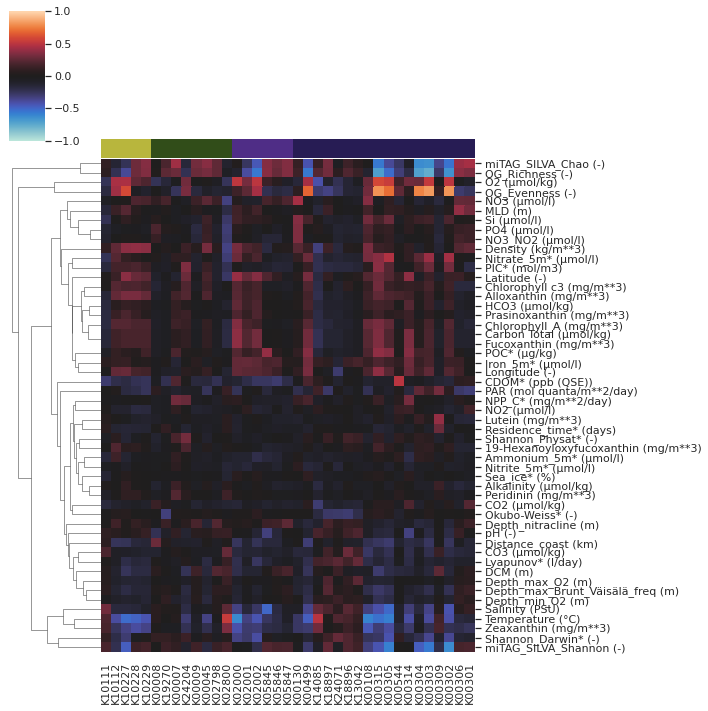

In [258]:
col_cols = envtest.columns.map(all_cdict)
sns.clustermap(test, vmin=-1, vmax=1, cmap=sns.color_palette("icefire", as_cmap=True),
               xticklabels =1, yticklabels=1, col_colors=col_cols, col_cluster=False)
plt.savefig('cluster-env_features.pdf')

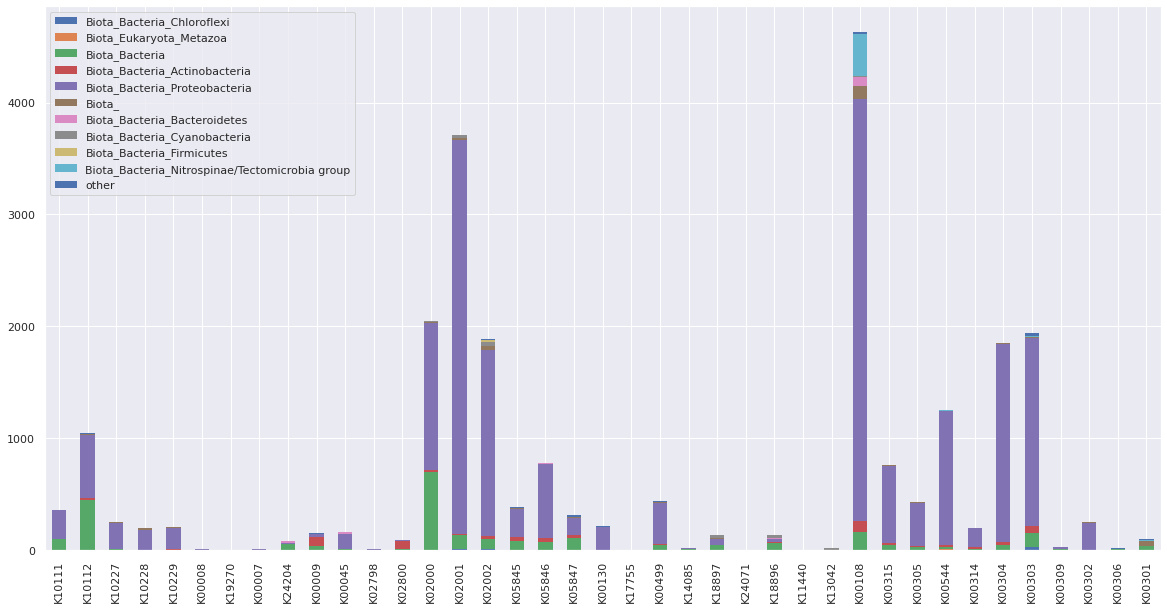

In [66]:
all_groups =[]
for K in all_cdict.keys():
    t = subset_abund[K]['Tbact']
    t['sub_taxa'] = t.taxonomy.str.split('; ').str[0:3].str.join('_')
    groups = t.groupby('sub_taxa').count().index
#     taxonomy.loc[groups, K]=t.groupby('sub_taxa').count()['taxonomy']
    all_groups.append(list(groups))
allgroup_flat = [item for sublist in all_groups for item in sublist]
taxonomy=pd.DataFrame(columns = all_cdict.keys(), index=set(allgroup_flat))
for K in all_cdict.keys():
    t = subset_abund[K]['Tbact']
    t['sub_taxa'] = t.taxonomy.str.split('; ').str[0:3].str.join('_')
    flat_list = [item for sublist in t for item in sublist]
    taxonomy[K] = t.groupby('sub_taxa').count()
taxonomy = taxonomy.fillna(0)
taxonomy2 = taxonomy
to_drop = taxonomy[taxonomy.sum(axis=1)<20].index
taxonomy.loc['other'] = taxonomy.loc[to_drop].sum()
taxonomy = taxonomy.drop(to_drop)
taxonomy.T.plot(kind='bar', stacked=True, lw=0, )
taxonomy_norm = taxonomy/taxonomy.sum()
plt.savefig('figures/TotalTranscripts_recovered_metaT.pdf')

In [68]:
passing_set = taxonomy.T.loc[taxonomy.sum(axis=0)>100].T.columns

<Figure size 864x576 with 0 Axes>

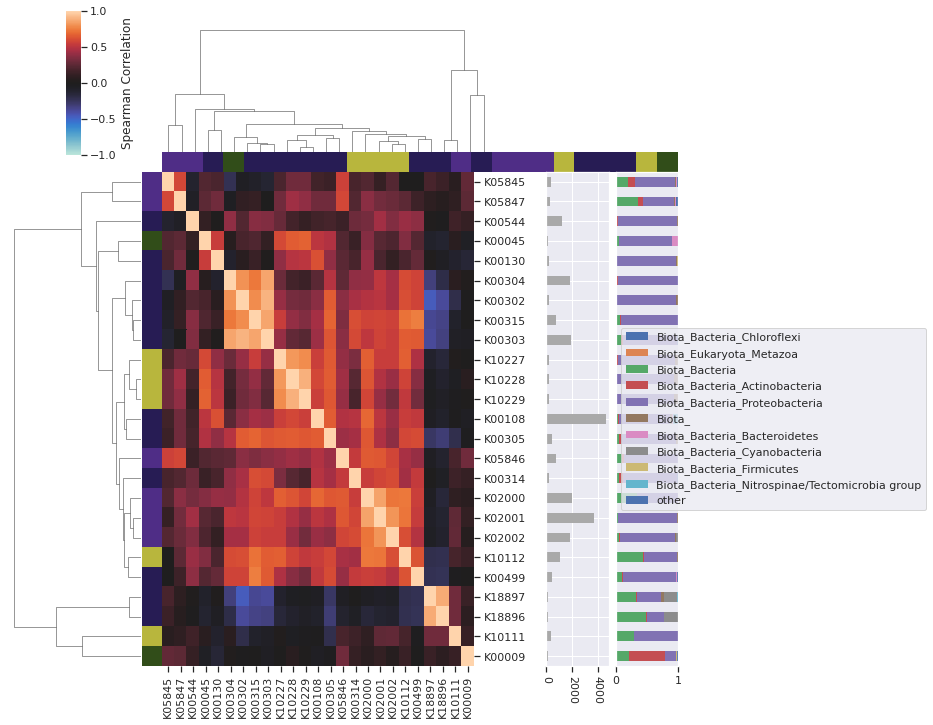

In [70]:
fig = plt.figure(figsize=[12,8])

MGB_combo_corr = MGB_combo.corr('spearman')
MGB_combo_corr = MGB_combo_corr.dropna(axis=1, how='all').dropna(axis=0, how='all')
MGB_combo_corr = MGB_combo_corr.loc[passing_set, passing_set]
row_colors = MGB_combo_corr.index.map(all_cdict)
row_colors

cluster=sns.clustermap(MGB_combo_corr, col_colors=row_colors, row_colors=row_colors,yticklabels=1, metric='braycurtis',
                 vmin=-1, vmax=1, cmap=sns.color_palette("icefire", as_cmap=True),
                  xticklabels =1,)# linewidths=0.1,


cluster.gs.update(right=0.95)
# divide existing axes
divider = make_axes_locatable(cluster.ax_heatmap)
divider2 = make_axes_locatable(cluster.ax_col_dendrogram)
# create new axes for bar plot 
ax = divider.append_axes("right", size="20%", pad=1)
ax2 = divider.append_axes("right", size="20%", pad=0.1)

# create empty space of same size as bar plot axes (don't use this space)
nax = divider2.new_horizontal(size="20%", pad=1.7)

target = [t.get_text() for t in np.array(cluster.ax_heatmap.get_yticklabels())]
ind= np.array([list(MGB_combo_corr.index.values).index(t) for t in target])
# # plot bar plot in ax
taxonomy_norm[target[::-1]].T.plot(kind='barh', ax = ax2, stacked=True,lw=0 )
taxonomy[target[::-1]].sum().plot(kind='barh', ax = ax, color='darkgrey', lw=0)
ax.set_yticklabels('')
ax2.set_yticklabels('')
ax.set_xticks([0,2000,4000])
ax.set_xticklabels([0,2000,4000], rotation=270)
ax2.set_xlim([0,1])
plt.rcParams['xtick.bottom'] = True
# ax.barh(np.arange(len(target)), taxonomy.values[ind], color='k')
# ax.set_yticklabels([])
# ax.set_ylim(-0.5,len(grouped_MMETSP.index)-.5)
# ax.invert_yaxis()
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.yaxis.set_ticks_position('left')
# ax.xaxis.set_ticks_position('top')
# if genome:
#     ax.set_xlabel('Total Genomes')
# else:
#     ax.set_xlabel('Total Transcriptomes')
# ax.xaxis.set_label_position('top') 
cluster.cax.set_position([0.1, .8, .02, 0.2])
cluster.cax.set_ylabel('Spearman Correlation')




plt.savefig('figures/clustermap.pdf')

In [74]:
for i in ['K02002', 'K05845', 'K00130', 'K14085', 'K18897', 'K13042', 'K00544']:
    if i  in passing_set:
        print(i)

K02002
K05845
K00130
K18897
K00544


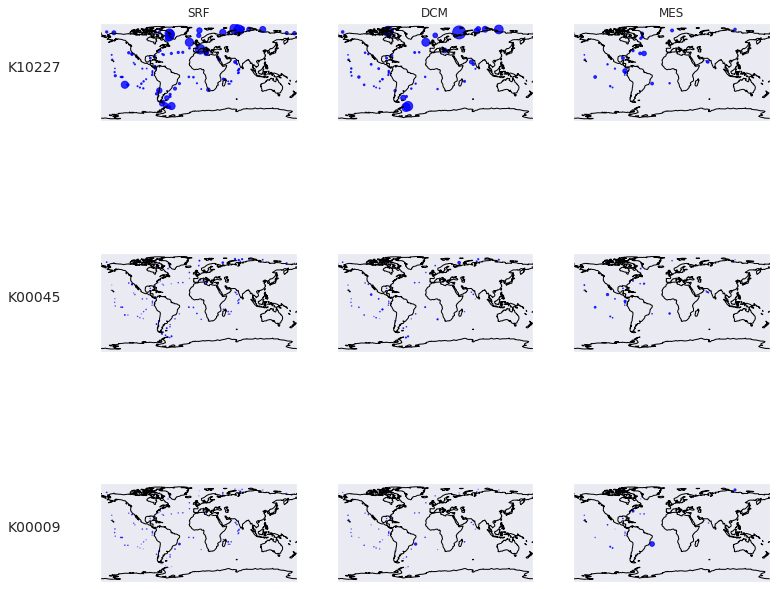

In [79]:
Kplot_maps_subplot(Tbact_summed_env, Klist=['K10227','K00045', 'K00009'], scale=2e5)
plt.savefig('figures/Mannitol_alldepths.pdf')

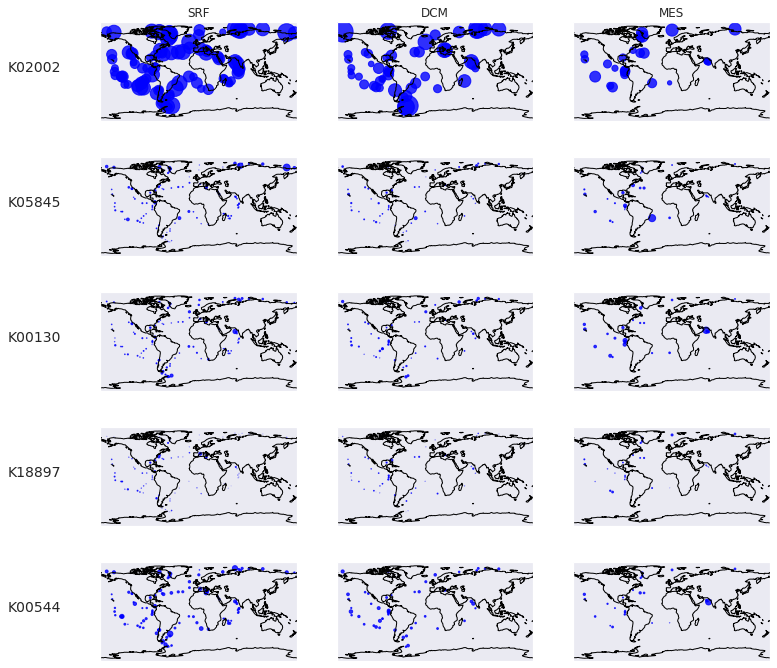

In [78]:
Kplot_maps_subplot(Tbact_summed, Klist=['K02002',
'K05845',
'K00130',
'K18897',
'K00544']
, scale=2e5)
plt.savefig('figures/GB_all_depths.pdf')

()

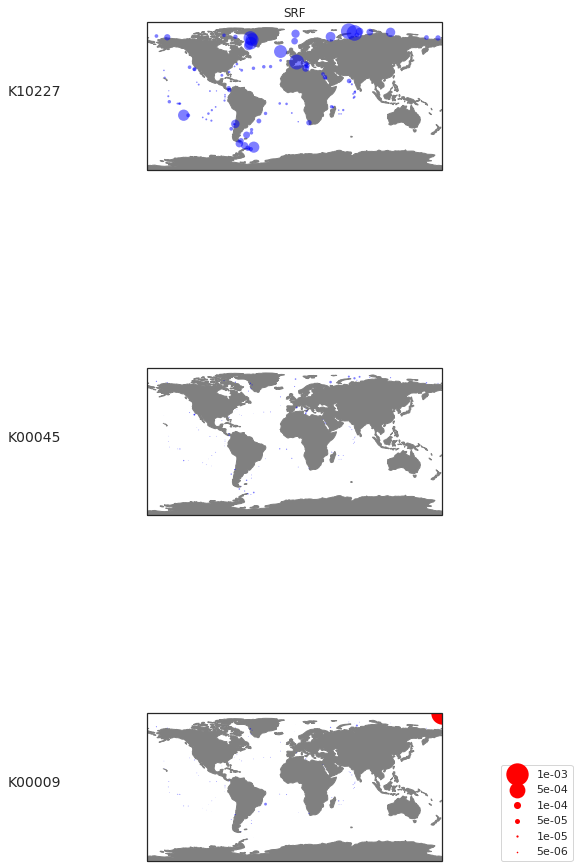

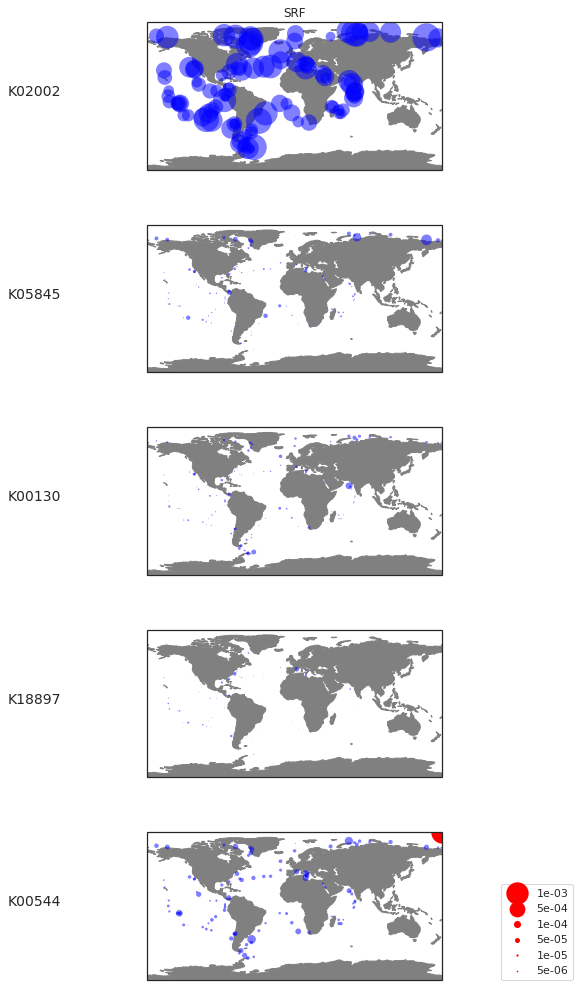

In [123]:
def Kplot_maps_subplot(Tbact_summed_env, Klist=['K00130'], kname='test', scale = 10e5, color='blue', depth_list = ['SRF', 'DCM', 'MES']):
    fig = plt.figure(figsize=(18, 18))
    gs = fig.add_gridspec(len(Klist), 3)
    for i, k in enumerate(Klist):
        for j,d in enumerate(depth_list):
            subset = Tbact_summed_env[Tbact_summed_env['depth']==d]
            ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())
#             ax.coastlines()
            ax.add_feature(cfeature.LAND, color = 'gray')
            ax.scatter(x =subset.longitude, y=subset.latitude, 
               s= subset[k]*scale, transform=ccrs.PlateCarree(), alpha=0.5,color=color, lw=0)
            ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
            if j == 0:
                ax.text(-350,1, k, fontsize=14)

            if i ==0:
                ax.set_title(d)
    legend_sizes = [1e-3, 5e-4, 1e-4, 5e-5,1e-5,5e-6]
    for i in legend_sizes:
        ax.scatter(x=180, y=90, s=i*scale, label='{:1.0e}'.format(i), color='red', lw=0)
    ax.legend(scatterpoints=1, loc=[1.2,0], ncol=1)
    plt.savefig(kname+'_Tbact.pdf')
    return()

Kplot_maps_subplot(Tbact_summed_env, Klist=['K10227','K00045', 'K00009'], kname='figures/mannitol', 
                   scale=5e5, depth_list = ['SRF'])

Kplot_maps_subplot(Tbact_summed_env, Klist=['K02002','K05845','K00130','K18897','K00544'], kname='figures/gb', 
                   scale=5e5, 
                   depth_list = ['SRF'])


()

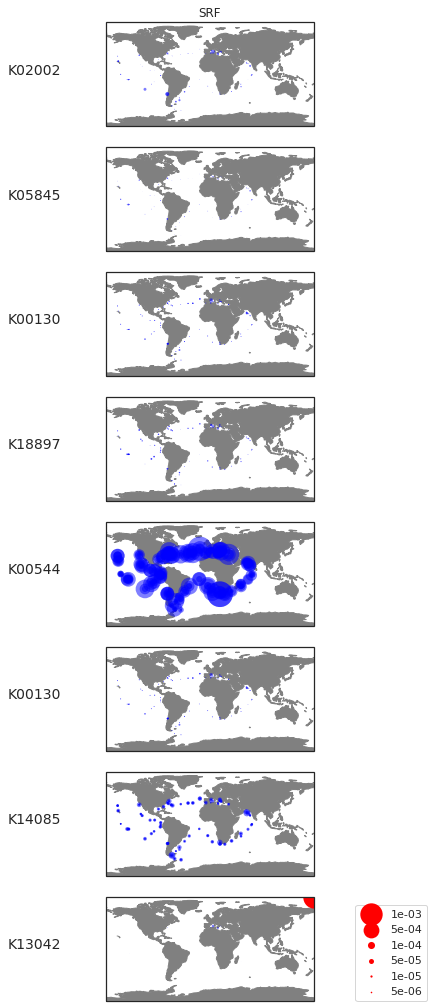

In [145]:
# Kplot_maps_subplot(Teuk_summed_env, Klist=['K10227','K00045', 'K00009'], kname='figures/euk_mannitol', 
#                    scale=5e5, depth_list = ['SRF'])

Kplot_maps_subplot(Teuk_summed_env, Klist=['K02002','K05845','K00130','K18897','K00544', 'K00130',
                                          'K14085', 'K13042'], kname='figures/euk_gb', 
                   scale=5e5, 
                   depth_list = ['SRF'])


()

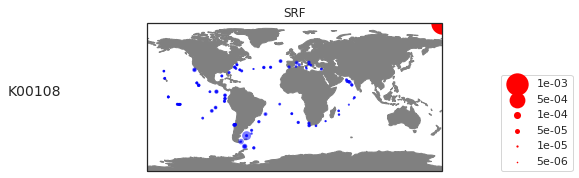

In [199]:
Kplot_maps_subplot(Teuk_summed_env, Klist=['K00108'], kname='figures/euk_gb', 
                   scale=5e5, 
                   depth_list = ['SRF'])


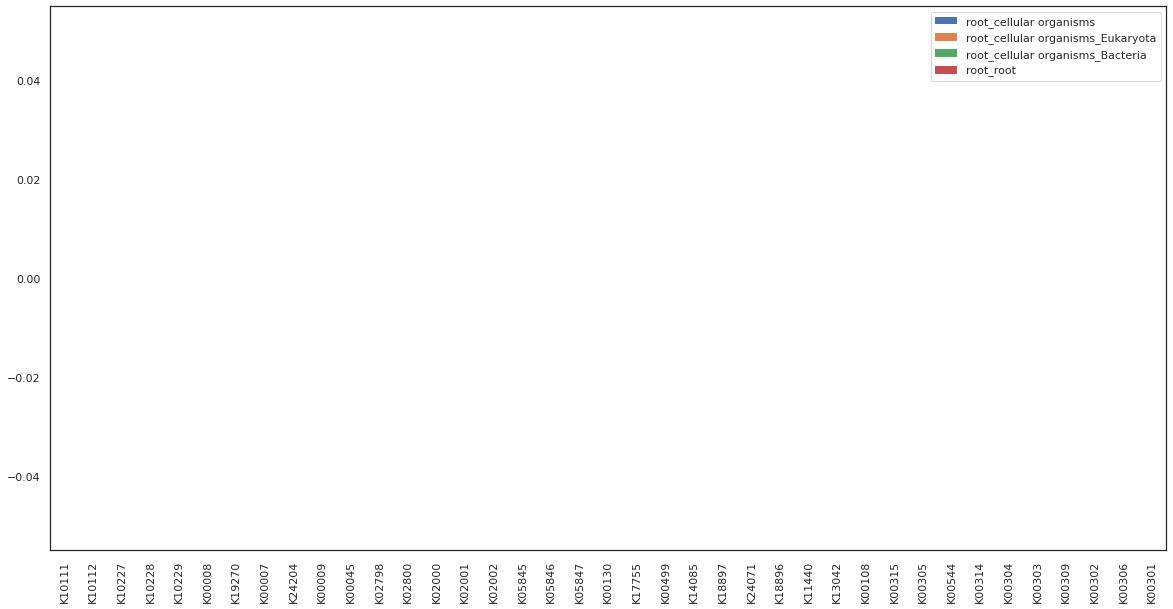

In [174]:
all_groups =[]
for K in all_cdict.keys():
    t = subset_abund[K]['Teuk']
    if 'taxonomy' not in t.columns:
        pass
    else:
        
        t['sub_taxa'] = t.taxonomy.str.split('; ').str[0:3].str.join('_')
        groups = t.groupby('sub_taxa').count().index
    #     taxonomy.loc[groups, K]=t.groupby('sub_taxa').count()['taxonomy']
        all_groups.append(list(groups))
allgroup_flat = [item for sublist in all_groups for item in sublist]
# print(allgroup_flat)
euk_taxonomy=pd.DataFrame(columns = all_cdict.keys(), index=set(allgroup_flat))
for K in all_cdict.keys():
    t = subset_abund[K]['Teuk']
    if 'taxonomy' not in t.columns:
        pass
    else:
        t['sub_taxa'] = t.taxonomy.str.split('; ').str[0:3].str.join(';')
        flat_list = [item for sublist in t for item in sublist]
        euk_taxonomy[K] = t.groupby('sub_taxa').count()
euk_taxonomy = euk_taxonomy.fillna(0)
euk_taxonomy.T.plot(kind='bar', stacked=True, lw=0, )
euk_taxonomy_norm = euk_taxonomy/euk_taxonomy.sum()
# plt.savefig('figures/TotalTranscripts_recovered_metaT.pdf')

<AxesSubplot:ylabel='taxonomy'>

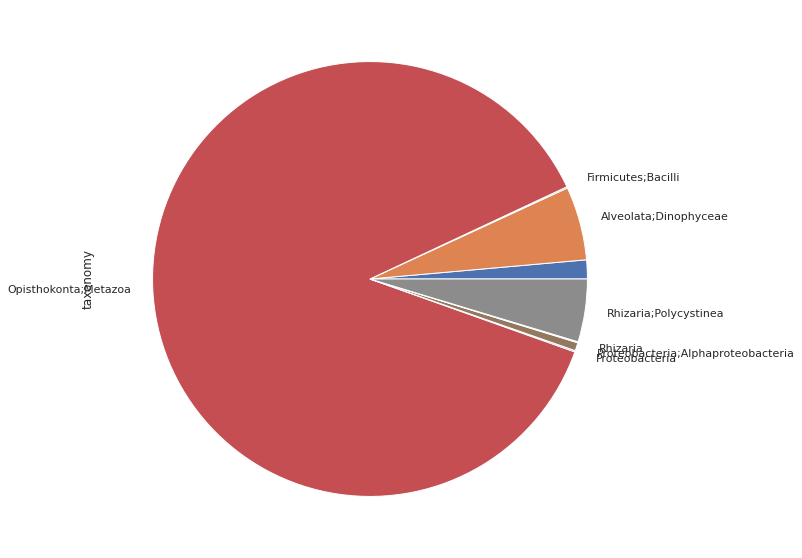

In [232]:
t = subset_abund['K00544']['Teuk']
t['grouping'] = t.taxonomy.str.split('; ').str[3:5].str.join(';').fillna('-')
t.groupby('grouping').count()['taxonomy'].plot(kind='pie',stacked=True)

In [242]:
pd.DataFrame(t.taxonomy.str.split(';').tolist()).to_csv('test-krona.csv',sep='\t',)

In [198]:
t = subset_abund['K00108']['Teuk']
t['grouping'] = t.taxonomy.str.split('; ').str[3:5].str.join(';').fillna('-')
t.groupby('grouping').count()

,taxonomy,TARA_A100000393,TARA_A100000394,TARA_A100000396,TARA_A100000398,TARA_A100000400,TARA_A100000402,TARA_A100000534,TARA_A100000536,TARA_A100000538,...,TARA_X000000410,TARA_X000000954,TARA_X000001006,TARA_X000001040,TARA_X000001043,TARA_X000001286,TARA_X000001288,TARA_X000001334,TARA_X000001338,sub_taxa
grouping,,,,,,,,,,,,,,,,,,,,,
,45,45,45,45,45,45,45,45,45,45,...,45,45,45,45,45,45,45,45,45,45
Actinobacteria;Actinobacteria,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
Alveolata,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Alveolata;Dinophyceae,102,102,102,102,102,102,102,102,102,102,...,102,102,102,102,102,102,102,102,102,102
Amoebozoa;Discosea,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
Cryptophyta,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Haptophyceae,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
Haptophyceae;Isochrysidales,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
Haptophyceae;Phaeocystales,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10


In [213]:
def Kplot_maps_subplot_euk(Tbact_summed_env, Klist=['K00130'], kname='test', scale = 10e5, color='blue', depth_list = ['[0.8-5µm]', '[5-20µm]', '[20-180µm]', '[180-2000µm]',]):
    fig = plt.figure(figsize=(18, 18))
    gs = fig.add_gridspec(len(Klist), 4)
    for i, k in enumerate(Klist):
        subset_big = Tbact_summed_env[Tbact_summed_env['depth']=='SRF']
        for j,d in enumerate(depth_list):
            
            subset = subset_big[subset_big['size fraction']==d]
            ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())
#             ax.coastlines()
            ax.add_feature(cfeature.LAND, color = 'gray')
            ax.scatter(x =subset.longitude, y=subset.latitude, 
               s= subset[k]*scale, transform=ccrs.PlateCarree(), alpha=0.5,color=color, lw=0)
            ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
            if j == 0:
                ax.text(-350,1, k, fontsize=14)

            if i ==0:
                ax.set_title(d)
    legend_sizes = [1e-3, 5e-4, 1e-4, 5e-5,1e-5,5e-6]
    for i in legend_sizes:
        ax.scatter(x=180, y=90, s=i*scale, label='{:1.0e}'.format(i), color='red', lw=0)
    ax.legend(scatterpoints=1, loc=[1.2,0], ncol=1)
    plt.savefig(kname+'_Tbact.pdf')
    return()


()

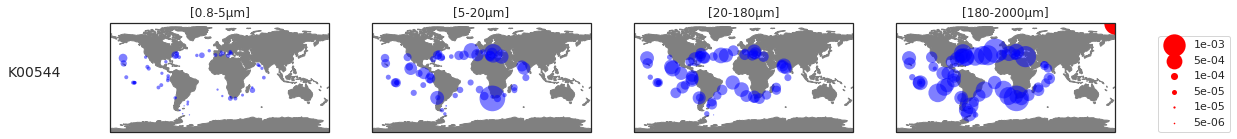

In [222]:
Kplot_maps_subplot_euk(Teuk_summed_env, Klist=['K00544' ], kname='figures/euk_gb', 
                   scale=5e5, )

In [210]:
Teuk_summed_env['size fraction'].unique()

array(['[0.8-5µm]', '[5-20µm]', '[20-180µm]', '[180-2000µm]',
       '[0.8-20µm]', '[>3µm]', '[>0.8µm]', '[0.8-3µm]'], dtype=object)